In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


We'll draw from the IMF using inverse-transform sampling. Let $r$ be a continuous random variable with a cumulative normalized distribution function $F_{r}$. Then the random variable $x=F_{r}\left(r\right)$ must have a uniform distribution on $\left[0,1\right]$. The inverse transform is just the inverse of this statement: If $x$ has a uniform distribution on $\left[0,1\right]$ and $r$ has a cumulative distribution $F_{r}$, then the cumulative distribution function of the random variable $F_{r}^{-1}\left(r\right)$ is $x$. 

In this case, we have 

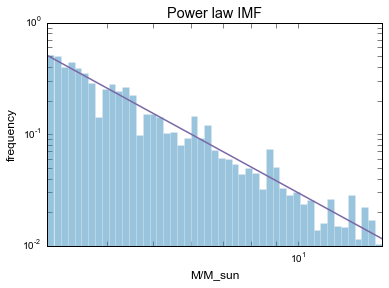

In [40]:
# problem 2a

def inv_cumulative_IMF(M, alpha = 2.35, m_min = 3, m_max = 15):
    '''
    helper function.
    '''
    inside = M*(m_max**(1 - alpha) - m_min**(1 - alpha)) + m_min**(1 - alpha)
    return inside**(1/(1 - alpha))
    
def draw_from_IMF(N, alpha = 2.35, m_min = 3, m_max = 15):
    '''
    generate N masses from a power-law IMF
    Use inverse-transform sampling, which is much faster than e.g. MCMC
    '''
    unifs = np.random.uniform(size = N)
    IMF = inv_cumulative_IMF(M = unifs, alpha = alpha, m_min = m_min, m_max = m_max)
    return IMF

def analytic_IMF(M, alpha = 2.35, m_min = 3, m_max = 15):
    '''returns the IMF normalized so that it will contain N stars'''
    c = (1/(1 - alpha) * (m_max**(1 - alpha) - m_min**(1 - alpha)))**(-1)
    return c * M**(-alpha) 

N_tot = 1000
masses = draw_from_IMF(N = N_tot, alpha = 2.35, m_min = 3, m_max = 15)
f = plt.figure(figsize = (6, 4))
ax = f.add_subplot(111)
xx = np.logspace(np.log10(3), np.log10(15))
ax.hist(masses, bins = xx, normed = True, alpha = 0.5)
ax.set_xlim(3, 15)
ax.grid(False)
ax.set_yscale('log', nonposy='clip')
ax.set_xscale('log')

ax.plot(xx, analytic_IMF(xx, alpha = 2.35, m_min=3, m_max = 15))
ax.set_xlabel('M/M_sun')
ax.set_ylabel('frequency')
ax.set_title('Power law IMF')

In [43]:
# problem 2b
import emcee 

def theta_is_within_bounds(theta, theta_bounds):
    '''
    theta should be an array of floats
    theta_bounds should be an array of 3 of e.g. [0, None], or [0, 20] 
    If there's a None, the prior won't be proper, so handle with care. 
    '''
    for i, param in enumerate(theta):
        this_min, this_max  = theta_bounds[i]
        
        if this_min is None:
            this_min = -np.inf
        if this_max is None:
            this_max = np.inf
        if not (this_min <= param < this_max):
            return False
    return True

def ln_flat_prior(theta, theta_bounds):
    '''
    theta is a vector, normally something like [alpha, m_max].
    theta is a vector of the same length, but with a list of length
        two (lower and upper bounds) at each element
    '''
    if theta_is_within_bounds(theta, theta_bounds):
        return 0
    else: 
        return -np.inf

def ln_likelihood(theta, m_i):
    '''
    I'm assuming here that theta =  [m_max, alpha] and we know m_min 
    here m_i are masses
    '''
    m_min = 0.5 # change this as necessary
    m_max, alpha = theta
    
    N_tot = 1/(1 - alpha) * (m_max**(1 - alpha) - m_min**(1 - alpha))
    c = 1/N_tot
    
    return np.sum(np.log(c) - alpha*np.log(m_i))
    
    
def ln_post(theta, theta_bounds, m_i):
    '''
    just ln_prior + ln_likelihood
    '''
    lnprior = ln_flat_prior(theta = theta, theta_bounds = theta_bounds)
    
    if np.isfinite(lnprior):
        lnlikelihood = ln_likelihood(theta = theta, m_i = m_i)
    else:
        lnlikelihood = 0 
    return lnprior + lnlikelihood
    

In [6]:
def get_good_p0_ball(p0, theta_bounds, nwalkers):
    '''
    p0 is a point in parameter space that we think might have a high probability. 
    This initalizes all nwalkers, making sure that they don't start somewhere with
    0 probability. 
    
    theta_bounds are the region in which the prior is finite
    '''
    num_good_p0 = 0
    

    ball_of_p0 = []
    while num_good_p0 < nwalkers:
        suggested_p0 = p0 + np.array([0.2*j*np.random.randn() for j in p0])
        suggested_p0_prob = ln_flat_prior(suggested_p0, theta_bounds = theta_bounds)
        
        if np.isfinite(suggested_p0_prob):
            ball_of_p0.append(suggested_p0)
            num_good_p0 += 1
    print("finished initializing walkers...")
    return ball_of_p0

def run_mcmc_known_m_min(p0, theta_bounds, m_i, nwalkers = 100, n_steps = 500, burn = 50):
    '''
    returns a sampler object
    '''
    ndim = len(p0)
    p0_ball = get_good_p0_ball(p0 = p0, theta_bounds = theta_bounds, nwalkers = nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post, args=[theta_bounds, m_i])
    pos, prob, state = sampler.run_mcmc(p0_ball, burn)
    
    sampler.reset()
    print('completed burn in ...')
    
    # now the main production run
    sampler.run_mcmc(pos, n_steps)
    return sampler
    


finished initializing walkers...
completed burn in ...


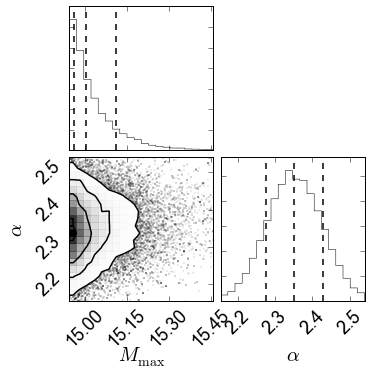

In [41]:
sampler = run_mcmc_known_m_min(p0 = [20, 2.5], theta_bounds = [[np.max(masses), 30], [1, 3]], 
                m_i = masses, nwalkers = 100, n_steps = 500, burn = 100)

import corner
fig = corner.corner(sampler.flatchain, range = [0.99, 0.99], labels = [r'$M_{\rm max}$', r'$\alpha$'],
                 label_kwargs={"fontsize": 20}, quantiles=[0.159, 0.5, 0.841])

axes = fig.get_axes()

for i, ax in enumerate(axes):
    ax.grid(False)
    ax.yaxis.set_tick_params(labelsize = 18)
    ax.xaxis.set_tick_params(labelsize = 18)

In [42]:
np.percentile(sampler.flatchain[:, 1], [15.9, 50, 84.1])

array([ 2.27709459,  2.35041888,  2.42700256])

(1.3, -0.6)

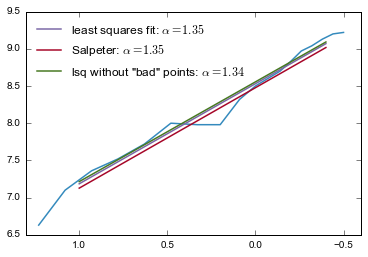

In [11]:
# for problem 3
log_M_plus_1 = np.array([0.5, 0.56, 0.62, 0.68, 0.74, 0.8, 0.86, 0.93, 
         1.0, 1.09, 1.2, 1.33, 1.48, 1.63, 1.78, 1.93, 2.08, 2.23])
log_xi_plus_10 = np.array([9.22, 9.2, 9.13, 9.04, 8.97, 8.83, 8.7, 8.6, 8.5, 
                  8.32, 7.98, 7.98, 8.0, 7.72, 7.52, 7.36, 7.10, 6.63])
log_M, log_xi = log_M_plus_1 - 1, log_xi_plus_10 - 10

# Salpeter says his fit is good for -0.4 < log_M < 1
log_M_cut = log_M[(log_M > -0.4) & (log_M < 1)]
log_xi_cut = log_xi[(log_M > -0.4) & (log_M < 1)]

f = plt.figure()
ax = f.add_subplot(111)
ax.plot(log_M_plus_1 - 1, log_xi_plus_10)
ax.set_xlim(ax.get_xlim()[::-1])


m, b = np.polyfit(log_M_cut, log_xi_cut, 1)
x = np.linspace(-0.4, 1)
y = m*x + b
y2 = np.log10(0.03) - 1.35*x
ax.plot(x, y+10, label = 'least squares fit: ' + r'$\alpha = %.2f$' % -m)
ax.plot(x, y2+10, label = 'Salpeter: ' + r'$\alpha = %.2f$' % 1.35)

# what if we discard his three 'bad' points?
mask = (log_xi_cut+10 > 7.97) & (log_xi_cut+10 < 8.01)
m3, b3 = np.polyfit(log_M_cut[~mask], log_xi_cut[~mask], 1)
y3 = m3*x + b3

ax.plot(x, y3+10, label = 'lsq without "bad" points: ' + r'$\alpha = %.2f$' % -m3)
ax.legend(loc = 'best', frameon = False)
ax.grid(False)
ax.set_xlim(1.3, -0.6)

In [79]:
# so the Salpeter IMF has dN/(dlogM) ~ M^-1.35 but dN/dM ~ M^-2.35

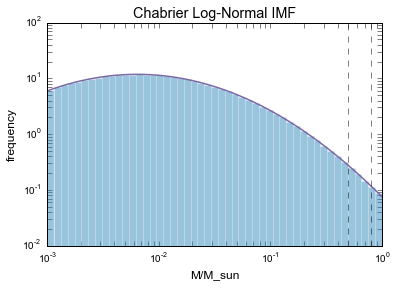

In [13]:
from scipy.special import erf, erfinv
def inverse_chabrier_cumulative(x, mu = 0.08, sigma = 0.69, m_min = 0.5, m_max = 0.8):
    '''
    obnoxiously complicated anaytic result, used in inverse transform sampling. 
    Would probably be faster to just use MCMC for sampling, but if I ever need 
    to generate a billion masses from a Chabrier IMF, this will be worth it. 
    '''
    coeff1 = erf((np.log10(m_max) - np.log10(mu))/(np.sqrt(2)*sigma)) 
    coeff2 = -erf((np.log10(m_min) - np.log10(mu))/(np.sqrt(2)*sigma))
    coeff = coeff1 + coeff2
    invarg = x*coeff + erf((np.log10(m_min) - np.log10(mu))/(np.sqrt(2)*sigma))
    return 10**(np.sqrt(2)*sigma*erfinv(invarg) + np.log10(mu))

def draw_masses_from_chabrier(N, m_min = 0.5, m_max = 0.8, mu = 0.08, sigma = 0.69):
    '''
    inverse transform sampling
    '''
    unifs = np.random.uniform(size = N)
    IMF = inverse_chabrier_cumulative(x = unifs, mu = mu, 
                sigma = sigma, m_min = m_min, m_max = m_max)
    return IMF

def analytic_chabrier(m, prefac = 0.158, m_min = 0.5, m_max = 0.8, mu = 0.08, sigma = 0.69):
    '''
    normalized so that the total area is 1
    '''
    coeff1 = erf((np.log10(m_max) - np.log10(mu))/(np.sqrt(2)*sigma))
    coeff2 = -erf((np.log10(m_min) - np.log10(mu))/(np.sqrt(2)*sigma))
    coeff = coeff1 + coeff2
    N_tot = prefac/2*np.sqrt(2*np.pi)*np.log(10)*sigma*coeff
    c = 1/N_tot
    return c*(prefac/m)*np.exp(-(np.log10(m) - np.log10(mu))**2/(2*sigma**2))

# just to test whether we're drawing masses from the right IMF
this_min, this_max = 1e-3, 1
many_chab_masses = draw_masses_from_chabrier(N = 1000000, m_min = this_min, m_max = this_max)
f = plt.figure(figsize = (6, 4))
ax = f.add_subplot(111)
xx = np.logspace(np.log10(this_min), np.log10(this_max))
ax.hist(many_chab_masses, bins = xx, normed = True, alpha = 0.5)
ax.set_xlim(this_min, this_max)
ax.grid(False)
ax.set_yscale('log', nonposy='clip')
ax.set_xscale('log')

ax.set_xlabel('M/M_sun')
ax.set_ylabel('frequency')
ax.set_title('Chabrier Log-Normal IMF')
ax.plot(xx, analytic_chabrier(xx, m_min = this_min, m_max = this_max))

# put some dotted lines to show region we'll sample from
ax.plot([0.5, 0.5], [1e-2, 1e2], 'k--', lw = 0.5)
ax.plot([0.8, 0.8], [1e-2, 1e2], 'k--', lw = 0.5)

# looks good. But in the region from which we're drawing our masses,
# this isn't significantly different from a power-law. 

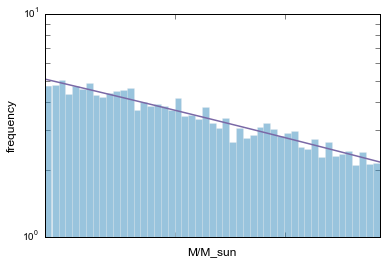

In [53]:
# let's draw some masses from this only in the range 0.5 < M < 0.8 and the
# fit a power-law IMF

chab_masses = draw_masses_from_chabrier(N = 10000, m_min = 0.5, m_max = 0.8)
f = plt.figure(figsize = (6, 4))
ax = f.add_subplot(111)
xx = np.logspace(np.log10(0.5), np.log10(0.8))
ax.hist(chab_masses, bins = xx, normed = True, alpha = 0.5)
ax.set_xlim(0.5, 0.8)
ax.grid(False)
ax.set_yscale('log', nonposy='clip')
ax.set_xscale('log')

ax.set_xlabel('M/M_sun')
ax.set_ylabel('frequency')
ax.plot(xx, analytic_chabrier(xx, m_min = 0.5, m_max = 0.8))

finished initializing walkers...
completed burn in ...


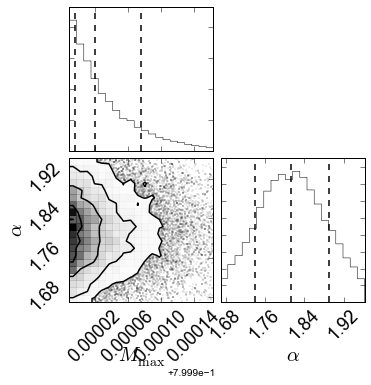

In [54]:
# theta = [m_max, alpha]
sampler = run_mcmc_known_m_min(p0 = [0.9, 2], theta_bounds = [[np.max(chab_masses), 1], [1.5, 2.5]], 
    m_i = chab_masses, nwalkers = 100, n_steps = 500, burn = 200) 

import corner
fig = corner.corner(sampler.flatchain, range = [0.95, 0.95], labels = [r'$M_{\rm max}$', r'$\alpha$'],
                 label_kwargs={"fontsize": 20}, quantiles=[0.159, 0.5, 0.841])

axes = fig.get_axes()

for i, ax in enumerate(axes):
    ax.grid(False)
    ax.yaxis.set_tick_params(labelsize = 18)
    ax.xaxis.set_tick_params(labelsize = 18)

In [55]:
np.percentile(sampler.flatchain[:, 1], [15.9, 50, 84.1])


array([ 1.73961815,  1.8135097 ,  1.8907707 ])

So if we draw masses from a Chabrier IMF in the range 0.5 - 0.8 M_sun and fit a simple power law, we get $\alpha = 1.81 - 1.97$, with a best-fit of $\alpha = 1.89$. This is somewhat lower than the Kroupa $\alpha = 2.3 \pm 0.3$ for $0.5 M_{\odot} < M < 1 M_{\odot}$ (note that the Kroupa error bars  "correspond approximately to 99 per
cent confidence intervals for $M >0.5 M_{\odot}$".) If we draw masses from a power-law IMF with $alpha = 1.89$, they're totally indistinguishable from those drawn from a Chabrier IMF in the same mass range. 

This is true even if we have a *lot* of masses. Here's 10 million from each:

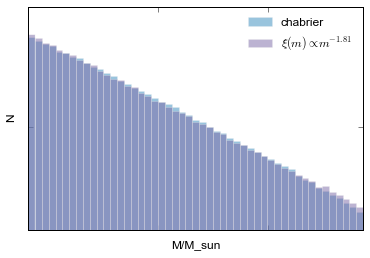

In [57]:
power_law_masses = draw_from_IMF(N = 10000000, alpha = 1.81, m_min = 0.5, m_max = 0.8)
chabrier_masses = draw_masses_from_chabrier(N = 10000000, m_min = 0.5, m_max = 0.8, mu = 0.08, sigma = 0.69)

f = plt.figure(figsize = (6, 4))
ax = f.add_subplot(111)
xx = np.logspace(np.log10(0.5), np.log10(0.8))
ax.hist(chabrier_masses, bins = xx, alpha = 0.5, label = 'chabrier')
ax.hist(power_law_masses, bins = xx, alpha = 0.5, label = r'$\xi(m)\propto m^{-1.81}$')
ax.legend(loc = 'best', frameon = False)
ax.set_xlim(0.5, 0.8)

ax.grid(False)
ax.set_yscale('log', nonposy='clip')
ax.set_xscale('log')
ax.set_ylim(1.6e5, 2.6e5)
ax.set_xlabel('M/M_sun')
ax.set_ylabel('N')


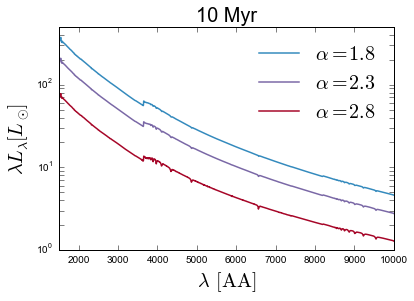

In [103]:
# problem 5
import fsps

imf_high_mass_alphas = [1.8, 2.3, 2.8]

all_lambdas, all_F_lambdas = [], []
for i, alpha in enumerate(imf_high_mass_alphas):
    sp = fsps.StellarPopulation(imf_type = 2, imf3 = alpha, sfh = 0, dust_type = 0)
    lamma, F_lambdas = sp.get_spectrum(tage = 0.01, peraa = True) # t_age in Gyr
    all_lambdas.append(lamma)
    all_F_lambdas.append(F_lambdas)
    
f = plt.figure()
ax = f.add_subplot(111)
ax.grid(False)
for i, lamma in enumerate(all_lambdas):
    ax.semilogy(lamma, lamma*all_F_lambdas[i], label = r'$\alpha =%.1f$' % imf_high_mass_alphas[i])
    
ax.set_xlim(1.5e3, 1e4)
ax.set_ylim(1, 500)
ax.set_xlabel(r'$\lambda\,{\rm [AA]}$', fontsize = 20)
ax.set_ylabel(r'$\lambda L_{\lambda}{ [L_{\odot}]}$', fontsize = 20)
ax.set_title('10 Myr', fontsize = 20)
ax.legend(loc = 'best', frameon = False, fontsize = 20)

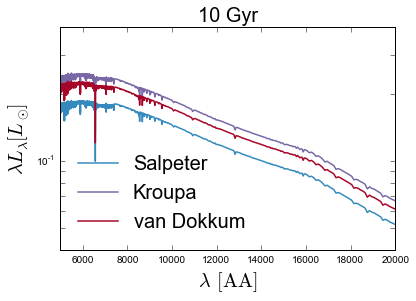

In [109]:
imf_types, imf_names = [0, 2, 3], ['Salpeter', 'Kroupa', 'van Dokkum']
all_lambdas, all_F_lambdas = [], []
for i, imftype in enumerate(imf_types):
    sp = fsps.StellarPopulation(imf_type = imftype, sfh = 0)
    lamma, F_lambdas = sp.get_spectrum(tage = 10, peraa = True) # t_age in Gyr
    all_lambdas.append(lamma)
    all_F_lambdas.append(F_lambdas)
    
f = plt.figure()
ax = f.add_subplot(111)
ax.grid(False)
for i, lamma in enumerate(all_lambdas):
    ax.semilogy(lamma, lamma*all_F_lambdas[i], label = imf_names[i])
    
ax.set_xlim(5e3, 2e4)
ax.set_ylim(0.04, 0.4)
ax.set_xlabel(r'$\lambda\,{\rm [AA]}$', fontsize = 20)
ax.set_ylabel(r'$\lambda L_{\lambda}{ [L_{\odot}]}$', fontsize = 20)
ax.set_title('10 Gyr', fontsize = 20)
ax.legend(loc = 'best', frameon = False, fontsize = 20)

In [117]:
# According to Madau (2014), "Where necessary to convert SFRs from the 
# literature from Chabrier or Kroupa IMFs to the Salpeter IMF, we divide 
# by constant factors of 0.63 (Chabrier) or 0.67 (Kroupa)." 

# In what mass range is this? Does it depend on stellar evolution models?
# Conroy & Van Dokkum say "a Salpeter IMF is ~60% heavier than a Kroupa IMF"
# Which sounds like it's true for a given luminosity. But wouldn't it depend
# on age and maybe metallicity too? 

# I guess you can ignore stellar death and just use L~M^3.5. 
# Yeah, apparently they assume 13 Gyr and Z_sun